#### importing the required libraries

In [1]:
# ==========================================
# IMPORTS
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import ttest_rel, wilcoxon
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


##### Loading the  Dataset

In [2]:
# ==========================================
# LOAD DATA
# ==========================================
df = pd.read_csv("../data/2022_Q1_OR_Utilization.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (2172, 13)


,index,Encounter ID,Date,OR Suite,Service,CPT Code,CPT Description,Booked Time (min),OR Schedule,Wheels In,Start Time,End Time,Wheels Out
0,0,10001,01/03/22,1,Podiatry,28110,"Partial ostectomy, fifth metatarsal head",90,01/03/22 07:00 AM,01/03/22 07:05 AM,01/03/22 07:32 AM,01/03/22 09:05 AM,01/03/22 09:17 AM
1,1,10002,01/03/22,1,Podiatry,28055,"Neurectomy, intrinsic musculature of foot",60,01/03/22 08:45 AM,01/03/22 09:48 AM,01/03/22 10:13 AM,01/03/22 11:01 AM,01/03/22 11:12 AM
2,2,10003,01/03/22,1,Podiatry,28297,Lapidus bunionectomy,150,01/03/22 10:00 AM,01/03/22 11:50 AM,01/03/22 12:20 PM,01/03/22 12:42 PM,01/03/22 12:58 PM
3,3,10004,01/03/22,1,Podiatry,28296,Bunionectomy with distal osteotomy,120,01/03/22 12:45 PM,01/03/22 01:29 PM,01/03/22 01:53 PM,01/03/22 02:50 PM,01/03/22 03:02 PM
4,4,10005,01/03/22,2,Orthopedics,27445,"Arthroplasty, knee, hinge prothesis",120,01/03/22 07:00 AM,01/03/22 07:15 AM,01/03/22 07:50 AM,01/03/22 09:38 AM,01/03/22 09:51 AM


###  Preprocessing the data
- The code converts time-related columns into proper datetime format and calculates the **actual surgery duration** in minutes.
- It removes rows with invalid duration values and **label-encodes categorical features** such as Service, CPT Description, and OR Suite to prepare the data for machine learning.


In [3]:

# Convert timestamps
time_cols = ["Date", "OR Schedule", "Wheels In", "Start Time", "End Time", "Wheels Out"]
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Create actual duration
df["Actual_Duration"] = (df["End Time"] - df["Start Time"]).dt.total_seconds() / 60

# Remove invalid durations
df = df[df["Actual_Duration"] > 0]

# Encode categorical features
cat_cols = ["Service", "CPT Description", "OR Suite"]
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

df.head()


,index,Encounter ID,Date,OR Suite,Service,CPT Code,CPT Description,Booked Time (min),OR Schedule,Wheels In,Start Time,End Time,Wheels Out,Actual_Duration
0,0,10001,2022-01-03,0,7,28110,23,90,2022-01-03 07:00:00,2022-01-03 07:05:00,2022-01-03 07:32:00,2022-01-03 09:05:00,2022-01-03 09:17:00,93.0
1,1,10002,2022-01-03,0,7,28055,21,60,2022-01-03 08:45:00,2022-01-03 09:48:00,2022-01-03 10:13:00,2022-01-03 11:01:00,2022-01-03 11:12:00,48.0
2,2,10003,2022-01-03,0,7,28297,18,150,2022-01-03 10:00:00,2022-01-03 11:50:00,2022-01-03 12:20:00,2022-01-03 12:42:00,2022-01-03 12:58:00,22.0
3,3,10004,2022-01-03,0,7,28296,5,120,2022-01-03 12:45:00,2022-01-03 13:29:00,2022-01-03 13:53:00,2022-01-03 14:50:00,2022-01-03 15:02:00,57.0
4,4,10005,2022-01-03,1,4,27445,3,120,2022-01-03 07:00:00,2022-01-03 07:15:00,2022-01-03 07:50:00,2022-01-03 09:38:00,2022-01-03 09:51:00,108.0


###  Exploratory Data Analysis (EDA)
- A histogram is used to show the **distribution of actual surgery durations**.
- A scatter plot compares **booked time vs actual duration** to identify any relationship.
- A boxplot visualizes how **surgery duration varies across different services**, helping detect outliers and patterns.


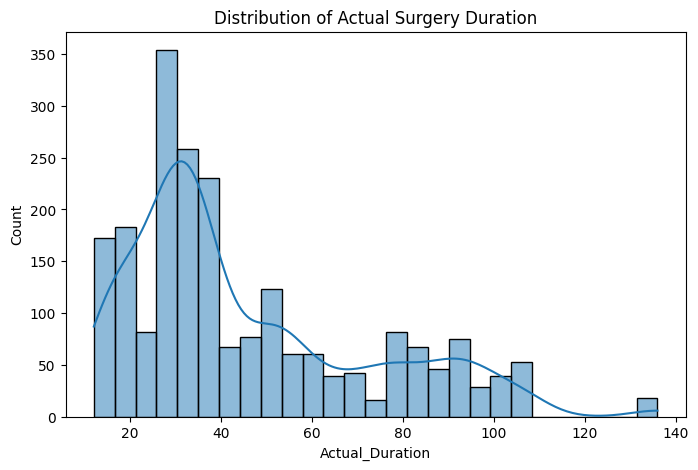

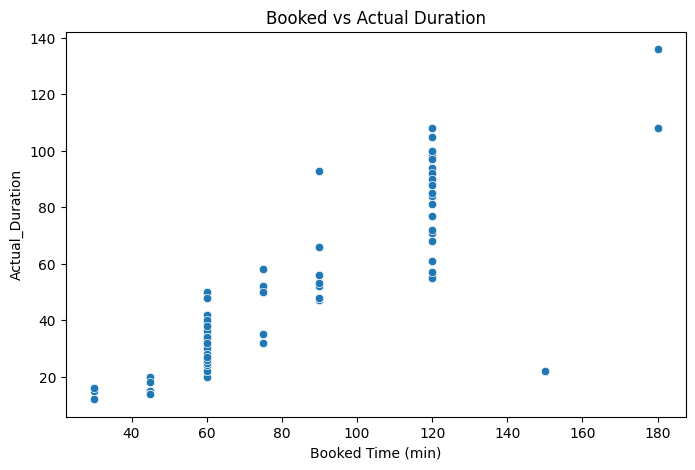

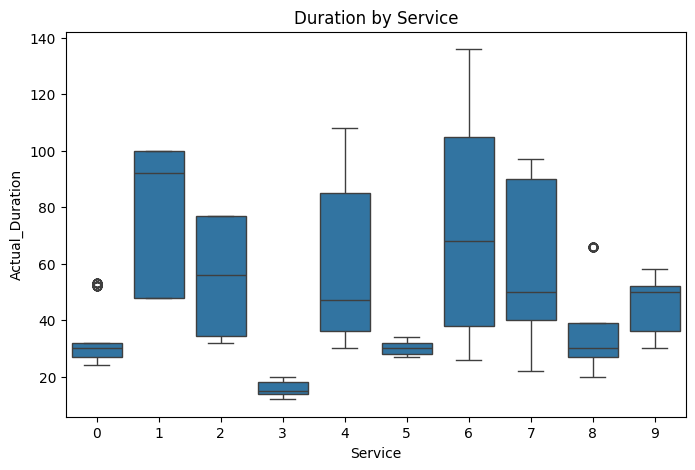

In [4]:
plt.figure(figsize=(8,5))
sns.histplot(df["Actual_Duration"], kde=True)
plt.title("Distribution of Actual Surgery Duration")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x=df["Booked Time (min)"], y=df["Actual_Duration"])
plt.title("Booked vs Actual Duration")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=df["Service"], y=df["Actual_Duration"])
plt.title("Duration by Service")
plt.show()


###  A/B Test: Booked vs Actual Duration
- Extracts the booked time and actual surgery duration for comparison.
- Performs a **Paired T-Test** to check if there's a significant difference between booked and actual times.
- Uses the **Wilcoxon test** as a non-parametric alternative when data is not normally distributed.
- Outputs both test statistics and p-values to evaluate significance.


In [6]:
booked = df["Booked Time (min)"]
actual = df["Actual_Duration"]

t_stat, p_val = ttest_rel(booked, actual)
print("Paired T-Test → T-stat:", t_stat, "P-value:", p_val)

w_stat, w_p = wilcoxon(booked, actual)
print("Wilcoxon Test → Stat:", w_stat, "P-value:", w_p)


Paired T-Test → T-stat: 106.74889572736893 P-value: 0.0
Wilcoxon Test → Stat: 171.0 P-value: 0.0


### Train-Test Split
- Selected important features and target variable.
- Split the dataset into **80% training** and **20% testing** using `train_test_split`.
- This prepares data for model training and evaluation.


In [7]:
features = ["Booked Time (min)", "Service", "CPT Code", "CPT Description", "OR Suite"]
X = df[features]
y = df["Actual_Duration"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Preprocessing Pipeline
- Separates **numerical and categorical columns** for proper preprocessing.
- Uses `StandardScaler` to scale numerical features.
- Categorical features are kept as-is using `"passthrough"`.
- The `ColumnTransformer` prepares data for consistent model input.


In [8]:
num_cols = ["Booked Time (min)", "CPT Code"]
cat_cols = ["Service", "CPT Description", "OR Suite"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols)
    ]
)


###  Hyperparameter Tuning with GridSearchCV
- A pipeline is created with preprocessing and a model step.
- GridSearchCV tests both **Random Forest** and **XGBoost** models with different hyperparameters.
- Uses **3-fold cross-validation** and **MAE scoring** to find the best model.
- The optimal model and its best parameters are printed after fitting.


In [9]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestRegressor())
])

param_grid = [
    {
        "model": [RandomForestRegressor()],
        "model__n_estimators": [200, 300],
        "model__max_depth": [12, 15],
        "model__min_samples_split": [2, 5]
    },
    {
        "model": [XGBRegressor(objective="reg:squarederror")],
        "model__n_estimators": [200, 300],
        "model__max_depth": [6, 8],
        "model__learning_rate": [0.05, 0.1]
    }
]

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best Model:", grid.best_estimator_)
print("Best Parameters:", grid.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Model: Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Booked Time (min)',
                                                   'CPT Code']),
                                                 ('cat', 'passthrough',
                                                  ['Service', 'CPT Description',
                                                   'OR Suite'])])),
                ('model',
                 RandomForestRegressor(max_depth=12, n_estimators=300))])
Best Parameters: {'model': RandomForestRegressor(), 'model__max_depth': 12, 'model__min_samples_split': 2, 'model__n_estimators': 300}


###  Model Evaluation
- Retrieves the best model from GridSearch and makes predictions on the test set.
- Calculates key evaluation metrics:
  - **MAE (Mean Absolute Error)**
  - **RMSE (Root Mean Squared Error)**
  - **R² Score** for model accuracy.
- Helps measure the performance of the final model.


In [10]:

best_model = grid.best_estimator_
preds = best_model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r2)


MAE: 3.455247060666171
RMSE: 5.966071048633556
R2 Score: 0.9510570655863348
